# STS Dataset leakage may be meaningful

In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
import numpy as np
from scipy.stats import spearmanr, pearsonr
import torch
import pandas as pd

model_name = 'sentence-transformers/stsb-distilroberta-base-v2'

In [2]:
def load_and_split_data():
    """Load STSb and create clean/overlapping splits"""
    # Load dataset
    ds = load_dataset("mteb/stsbenchmark-sts")
    ds_test = ds['test']
    ds_train = ds['train']

    # Get unique training sentences
    train_sentences = set(ds_train['sentence1'] + ds_train['sentence2'])

    # Create masks for overlapping and clean pairs
    overlapping_mask = [
        s1 in train_sentences or s2 in train_sentences
        for s1, s2 in zip(ds_test['sentence1'], ds_test['sentence2'])
    ]

    # Split into overlapping and clean subsets
    overlap_indices = [i for i, m in enumerate(overlapping_mask) if m]
    clean_indices = [i for i, m in enumerate(overlapping_mask) if not m]

    return ds_test, overlap_indices, clean_indices

def evaluate_model(model, dataset, indices=None):
    """Evaluate model on specified subset of data"""
    if indices is None:
        indices = range(len(dataset))

    # Get sentences and scores for subset
    sentences1 = [dataset['sentence1'][i] for i in indices]
    sentences2 = [dataset['sentence2'][i] for i in indices]
    scores = [dataset['score'][i] for i in indices]

    # Normalize ground truth scores to 0-1
    scores = np.array(scores) / 5.0

    # Get embeddings
    with torch.no_grad():
        embeddings1 = model.encode(sentences1, convert_to_tensor=True)
        embeddings2 = model.encode(sentences2, convert_to_tensor=True)

    # Compute cosine similarities
    cos_scores = util.cos_sim(embeddings1, embeddings2)
    predictions = cos_scores.diagonal().cpu().numpy()

    # Compute metrics
    spearman_corr, _ = spearmanr(predictions, scores)
    pearson_corr, _ = pearsonr(predictions, scores)

    return {
        'spearman': spearman_corr,
        'pearson': pearson_corr,
        'n_samples': len(indices)
    }

def run_evaluation():
    # Load data and get splits
    test_dataset, overlap_indices, clean_indices = load_and_split_data()

    # Load model
    model = SentenceTransformer(model_name, trust_remote_code=True, device="cuda")

    # Run evaluations
    results = {
        'full': evaluate_model(model, test_dataset),
        'overlapping': evaluate_model(model, test_dataset, overlap_indices),
        'clean': evaluate_model(model, test_dataset, clean_indices)
    }

    # Create results DataFrame
    df_results = pd.DataFrame({
        'Split': ['Full Test Set', 'Overlapping Pairs', 'Clean Pairs'],
        'Samples': [results[k]['n_samples'] for k in ['full', 'overlapping', 'clean']],
        'Spearman': [results[k]['spearman'] for k in ['full', 'overlapping', 'clean']],
        'Pearson': [results[k]['pearson'] for k in ['full', 'overlapping', 'clean']]
    })

    return df_results

# Run evaluation and display results
results = run_evaluation()
print("\nEvaluation Results:")
print(results.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

/home/bufo/current/research/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Evaluation Results:
            Split  Samples  Spearman  Pearson
    Full Test Set     1379    0.8641   0.8634
Overlapping Pairs      249    0.9161   0.9116
      Clean Pairs     1130    0.8505   0.8521


In [10]:
from tqdm import tqdm
def random_subset_evaluation(model, dataset, subset_size, n_iterations=500):
    """
    Repeatedly evaluate the model on random subsets of the data to establish
    a baseline for performance variation.
    """
    full_indices = list(range(len(dataset)))
    baseline_results = []
    
    for _ in tqdm(range(n_iterations)):
        # Randomly sample subset_size indices without replacement
        random_indices = np.random.choice(
            full_indices, 
            size=subset_size, 
            replace=False
        )
        
        # Evaluate on this random subset
        result = evaluate_model(model, dataset, random_indices)
        baseline_results.append({
            'spearman': result['spearman'],
            'pearson': result['pearson']
        })
    
    return pd.DataFrame(baseline_results)

def enhanced_evaluation():
    # Load data and model as before
    test_dataset, overlap_indices, clean_indices = load_and_split_data()
    model = SentenceTransformer(model_name, trust_remote_code=True, device="cuda")
    
    # Original evaluations
    results = {
        'full': evaluate_model(model, test_dataset),
        'overlapping': evaluate_model(model, test_dataset, overlap_indices),
        'clean': evaluate_model(model, test_dataset, clean_indices)
    }
    
    # Run random sampling analysis
    clean_size = len(clean_indices)
    random_results = random_subset_evaluation(model, test_dataset, clean_size)
    
    # Calculate statistics from random samples
    random_stats = {
        'spearman_mean': random_results['spearman'].mean(),
        'spearman_std': random_results['spearman'].std(),
        'spearman_95_interval': np.percentile(random_results['spearman'], [2.5, 97.5]),
        'pearson_mean': random_results['pearson'].mean(),
        'pearson_std': random_results['pearson'].std(),
        'pearson_95_interval': np.percentile(random_results['pearson'], [2.5, 97.5])
    }
    
    return results, random_results, random_stats

# Run the enhanced evaluation
results, random_results, random_stats = enhanced_evaluation()

print("\nActual Results:")
print(f"Full Set Spearman: {results['full']['spearman']:.4f}")
print(f"Clean Set Spearman: {results['clean']['spearman']:.4f}")
print(f"Difference: {results['full']['spearman'] - results['clean']['spearman']:.4f}")
print()
print(f"Full Set Pearson: {results['full']['pearson']:.4f}")
print(f"Clean Set Pearson: {results['clean']['pearson']:.4f}")
print(f"Difference: {results['full']['spearman'] - results['clean']['spearman']:.4f}")

print("\nRandom Sampling Statistics:")
print(f"Mean Spearman on random subsets: {random_stats['spearman_mean']:.4f}")
print(f"Std Dev of Spearman: {random_stats['spearman_std']:.4f}")
print(f"95% Confidence Interval: [{random_stats['spearman_95_interval'][0]:.4f}, {random_stats['spearman_95_interval'][1]:.4f}]")
print()
print(f"Mean Pearson on random subsets: {random_stats['pearson_mean']:.4f}")
print(f"Std Dev of Pearson: {random_stats['pearson_std']:.4f}")
print(f"95% Confidence Interval: [{random_stats['pearson_95_interval'][0]:.4f}, {random_stats['pearson_95_interval'][1]:.4f}]")


Actual Results:
Full Set Spearman: 0.8641
Clean Set Spearman: 0.8505
Difference: 0.0136

Full Set Pearson: 0.8634
Clean Set Pearson: 0.8521
Difference: 0.0136

Random Sampling Statistics:
Mean Spearman on random subsets: 0.8644
Std Dev of Spearman: 0.0034
95% Confidence Interval: [0.8578, 0.8710]

Mean Pearson on random subsets: 0.8638
Std Dev of Pearson: 0.0030
95% Confidence Interval: [0.8581, 0.8692]


## Are the bootstrapped scores normal?

Shapiro-Wilk test results:
Statistic: 0.9978
P-value: 0.7763

At α = 0.05:
Fail to reject the null hypothesis that the data is normally distributed
Kolmogorov-Smirnov test results:
Statistic: 0.0274
P-value: 0.8381

At α = 0.05:
Fail to reject the null hypothesis that the data is normally distributed

Shapiro-Wilk test results:
Statistic: 0.9968
P-value: 0.4192

At α = 0.05:
Fail to reject the null hypothesis that the data is normally distributed
Kolmogorov-Smirnov test results:
Statistic: 0.0251
P-value: 0.9022

At α = 0.05:
Fail to reject the null hypothesis that the data is normally distributed

AndersonResult(statistic=0.23994787230509473, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.8643750344962194, scale=0.0033920877059568397)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=0.43558771415729325, critical_value

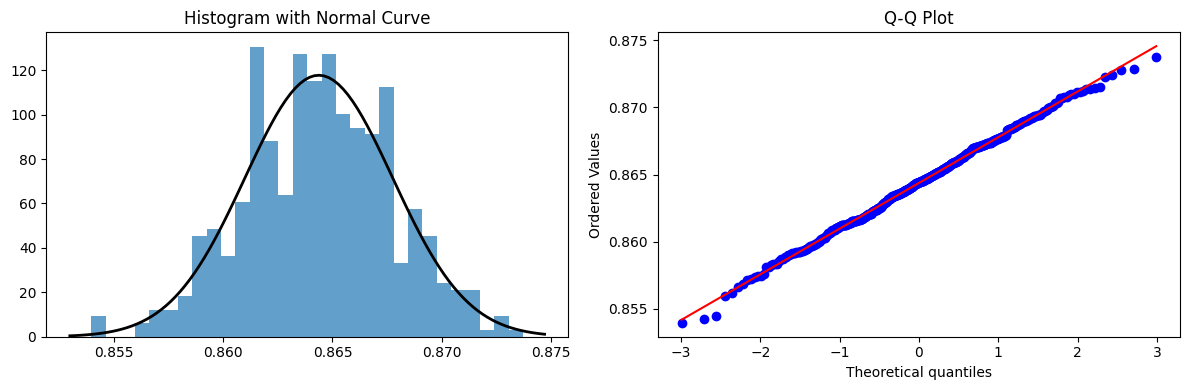

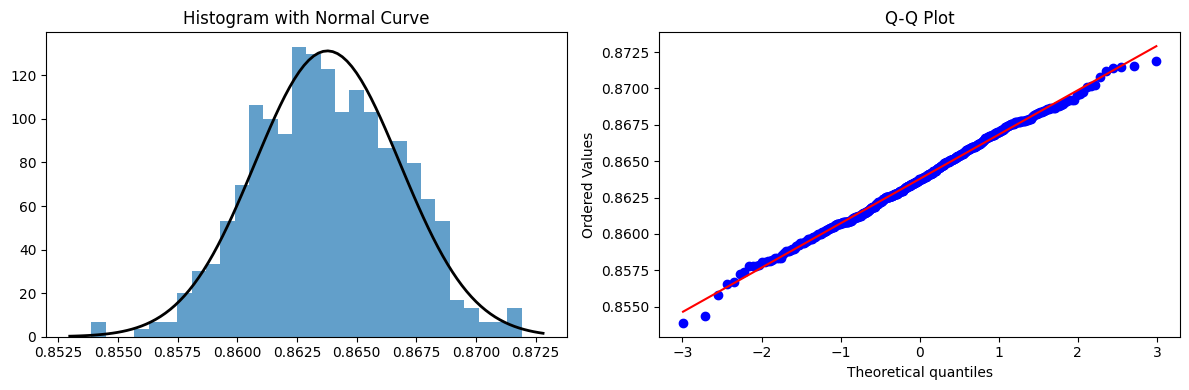

In [14]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def check_normality(data):
    # Perform Shapiro-Wilk test
    statistic, p_value = stats.shapiro(data)
    
    print(f"Shapiro-Wilk test results:")
    print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # General interpretation
    alpha = 0.05  # conventional significance level
    print(f"\nAt α = {alpha}:")
    print(f"{'Reject' if p_value < alpha else 'Fail to reject'} the null hypothesis that the data is normally distributed")
    
    # Visual checks
    import matplotlib.pyplot as plt
    
    # Create Q-Q plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram with density curve
    ax1.hist(data, bins=30, density=True, alpha=0.7)
    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(data), np.std(data))
    ax1.plot(x, p, 'k', linewidth=2)
    ax1.set_title('Histogram with Normal Curve')
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot')
    
    plt.tight_layout()
    return plt

def ks_normality_test(data):
    # First, standardize the data
    # This is because the KS test compares to a standard normal distribution
    standardized_data = (data - np.mean(data)) / np.std(data)
    
    # Perform KS test against normal distribution
    statistic, p_value = stats.kstest(standardized_data, 'norm')
    
    print(f"Kolmogorov-Smirnov test results:")
    print(f"Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    alpha = 0.05
    print(f"\nAt α = {alpha}:")
    print(f"{'Reject' if p_value < alpha else 'Fail to reject'} the null hypothesis that the data is normally distributed")
    print()

check_normality(random_results['spearman'])
ks_normality_test(random_results['spearman'])
check_normality(random_results['pearson'])
ks_normality_test(random_results['pearson'])

print(stats.anderson(random_results['spearman']))
print(stats.anderson(random_results['pearson']))

## They're normal, so a z-score is appropriate

In [9]:
# Our 'clean' set's spearman correlation
x = results['clean']['spearman']

# mean and std of our bootstrap results
s = random_stats['spearman_std']
m = random_stats['spearman_mean']

z = (x - m) / s
print("Spearman z-score is:", z)

# Our 'clean' set's pearson correlation
x = results['clean']['pearson']

# mean and std of our bootstrap results
s = random_stats['pearson_std']
m = random_stats['pearson_mean']

z = (x - m) / s
print("Pearson z-score is:", z)

Spearman z-score is: -4.097583571718964
Pearson z-score is: -3.8505368962982987


In [17]:
from datasets import load_dataset

# Load in sentence similarity benchmark. Form is (sentence1, sentence2, similarity score)
ds = load_dataset("mteb/stsbenchmark-sts")
ds_test = ds['test']
ds_train = ds['train']

# Unique sentences in test set
test_unique = set(zip(ds_test['sentence1'], ds_test['sentence2']))

# Unique sentences in train set
train_unique = set(zip(ds_train['sentence1'], ds_train['sentence2']))

# % of train set containing sentences common to train and test
#len(test_unique & train_unique) / len(ds_test)
test_unique & train_unique

{('A man is playing a flute.', 'A man is playing a guitar.'),
 ('Ankeet Chavan granted conditional bail for marriage',
  'Ankeet Chavan granted bail to get married'),
 ("Car bomb at Swedish consulate in Libya's Benghazi, no casualties",
  'Car Bomb Hits Swedish Consulate in Benghazi, None Hurt'),
 ('Iran, six global powers sign landmark nuclear deal',
  'Iran, world powers agree nuclear deal'),
 ('New Zealand set to legalise gay marriage',
  'New Zealand votes to legalise same-sex marriage'),
 ('Rogers, Videotron extend reach with network-sharing deal',
  'Rogers, Videotron reach network-sharing, spectrum deal'),
 ('Ten rescued off Waterford, Dublin coasts',
  'Six rescued after boat capsizes in Dublin Bay')}

I don't really know who/where else to ask this, but I found something interesting while working on our final project that I wanted to share and possibly get some advice on. My statistical knowledge isn't very good, so I'm wondering if anyone has any advice :)

Our project focuses on sentence similarity and to do our supervised training and evaluation we use the STSB dataset (Found here among many other places). It's a pretty simple dataset comprising of just pairs of sentences and a human rated similarity score between them.

While working on improving my model, I decided to dive a little deeper into the dataset and ran the following code

```
from datasets import load_dataset

# Load in sentence similarity benchmark. Form is (sentence1, sentence2, similarity score)
ds = load_dataset("mteb/stsbenchmark-sts")
ds_test = ds['test']
ds_train = ds['train']

# Unique sentences in test set
test_unique = set(ds_test['sentence1'] + ds_test['sentence2'])

# Unique sentences in train set
train_unique = set(ds_train['sentence1'] + ds_train['sentence2'])

# % of train set containing sentences common to train and test
len(test_unique & train_unique) / len(ds_test)
```

Any guess on what the output of this might be? Ideally zero right? Not even close. It comes out to ~18% overlap. But maybe this isn't a big deal right? It's not obvious to me that sentence similarity, as long as the "seen" sentences are paired with an "unseen" sentence (For which almost all of these are. There are in fact some duplicates)